<a href="https://colab.research.google.com/github/lb424/Dog-Breed-Identification/blob/main/Dog_Breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
import os
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
labels = pd.read_csv('/content/drive/MyDrive/dog-breed-identification/labels.csv')
labels.head()
train_folder = '/content/drive/MyDrive/dog-breed-identification/train'
labels['file_name'] = labels['id'].apply(lambda x: os.path.join(train_folder, f"{x}.jpg"))
print(labels.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                 id             breed  \
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull   
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo   
2  001cdf01b096e06d78e9e5112d419397          pekinese   
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick   
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever   

                                           file_name  
0  /content/drive/MyDrive/dog-breed-identificatio...  
1  /content/drive/MyDrive/dog-breed-identificatio...  
2  /content/drive/MyDrive/dog-breed-identificatio...  
3  /content/drive/MyDrive/dog-breed-identificatio...  
4  /content/drive/MyDrive/dog-breed-identificatio...  


In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels['encoded'] = lb.fit_transform(labels['breed']).tolist()

In [ ]:
train, val = train_test_split(labels, test_size=0.2, stratify=labels['breed'], random_state=42)

In [ ]:
Image_size = 143
batch_size = 64

train_dg = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_dg = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_g = train_dg.flow_from_dataframe(
    dataframe=train,
    x_col='file_name',
    y_col='breed',
    target_size=(Image_size, Image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_g = val_dg.flow_from_dataframe(
    dataframe=val,
    x_col='file_name',
    y_col='breed',
    target_size=(Image_size, Image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
model = MobileNetV2(input_shape=(Image_size, Image_size, 3),
                    include_top=False,
                    weights='imagenet')
model.trainable = False

<ipython-input-37-bb591166f0fb>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(input_shape=(Image_size, Image_size, 3),


In [ ]:
model2 = tf.keras.Sequential([
    model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(120, activation='softmax')
])
model2.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_acc_all_epochs = []
train_loss_all_epochs = []
val_acc_all_epochs = []
val_loss_all_epochs = []

history = model2.fit(
    train_g,
    epochs=5,
    validation_data=val_g,
    callbacks=[
        keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: (
                train_acc_all_epochs.append(logs.get('accuracy', 0)),
                train_loss_all_epochs.append(logs.get('loss', 0)),
                val_acc_all_epochs.append(logs.get('val_accuracy', 0)),
                val_loss_all_epochs.append(logs.get('val_loss', 0))
            )
        )
    ]
)



Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.0430 - loss: 4.9955 - val_accuracy: 0.1971 - val_loss: 3.4955
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.2583 - loss: 3.1974 - val_accuracy: 0.3604 - val_loss: 2.6875
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.3896 - loss: 2.5072 - val_accuracy: 0.4215 - val_loss: 2.3347
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.4678 - loss: 2.1260 - val_accuracy: 0.4548 - val_loss: 2.1569
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 369s 2s/step - accuracy: 0.5044 - loss: 1.9225 - val_accuracy: 0.4689 - val_loss: 2.0456


32/32 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.4615 - loss: 2.0723
Validation Loss: 2.0456
Validation Accuracy: 46.89%
Training Accuracy: 50.31%


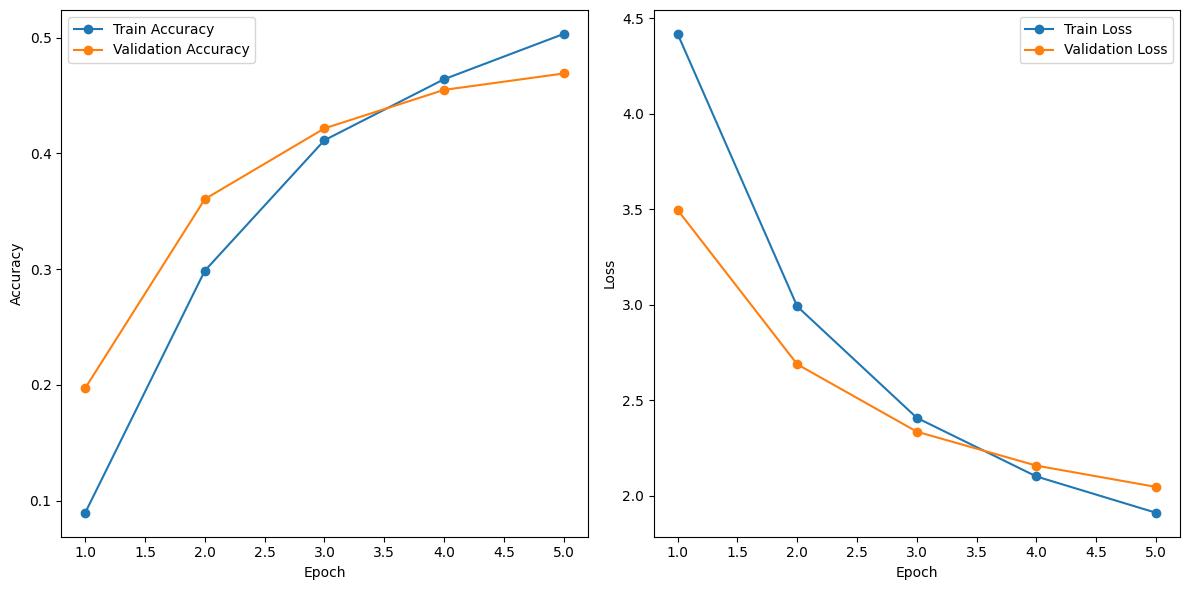

In [ ]:
num_epochs = len(train_acc_all_epochs)
epochs = range(1, num_epochs + 1)

val_loss, val_accuracy = model2.evaluate(val_g)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
train_accuracy = history.history['accuracy'][-1]
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_all_epochs, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc_all_epochs, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_all_epochs, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_all_epochs, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


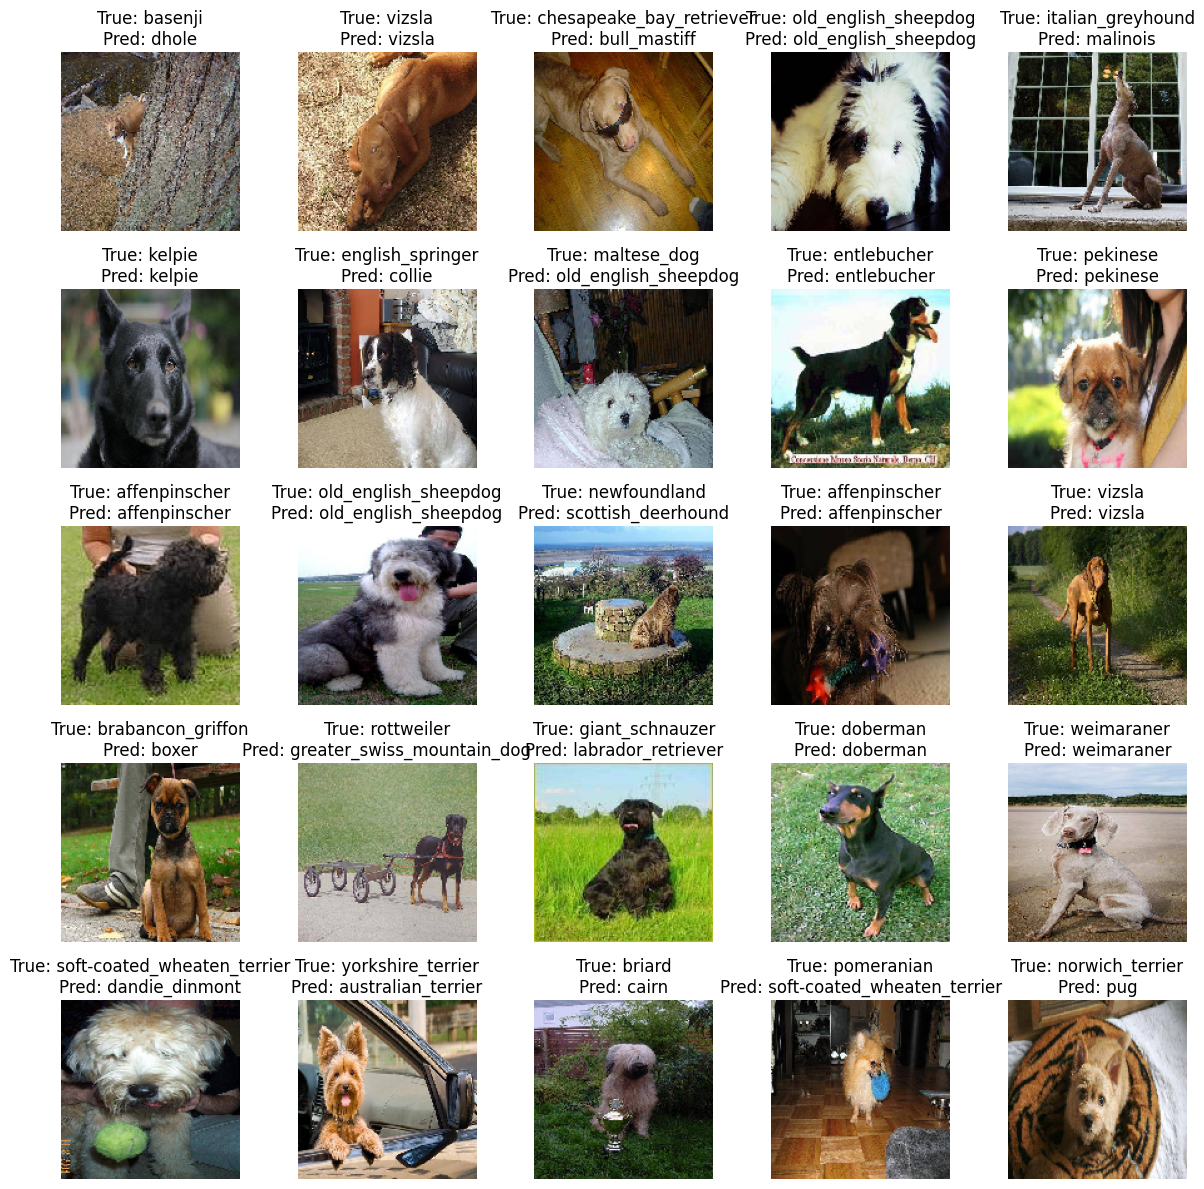

In [ ]:
images, true_labels = next(val_g)
predictions = model2.predict(images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(true_labels, axis=1)
class_labels = list(train_g.class_indices.keys())

plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    true_label = class_labels[true_classes[i]]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
